# Classification model on Customer_Churn Dataset
 -by Muhammad Ejaz
 

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import joblib, warnings, os, json
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, RocCurveDisplay,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
import shap


Load dataset

In [2]:

# Load file from local directory
df=pd.read_csv(r'E:\DATA Science\portfolio project\Nexus\customer_churn.csv')

print("Shape:", df.shape)
df.head()

Shape: (900, 10)


,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [3]:
df.info()
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


Names              0
Age                0
Total_Purchase     0
Account_Manager    0
Years              0
Num_Sites          0
Onboard_date       0
Location           0
Company            0
Churn              0
dtype: int64

EDA

In [4]:
# Example: drop rows with missing target
df = df.dropna(subset=["Churn"])   # adjust column name if different

# Convert target to 0/1
target_col = "Churn"
if df[target_col].dtype == "object":
    df[target_col] = df[target_col].map({"Yes":1, "No":0})

# Quick class balance
print(df[target_col].value_counts(normalize=True))

Churn
0    0.833333
1    0.166667
Name: proportion, dtype: float64


Feature matrix / target split


In [5]:
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("Numeric:", len(num_cols), "  Categorical:", len(cat_cols))

Numeric: 5   Categorical: 4


Pre-processing pipeline


In [6]:
numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ])

# Choose imbalance strategy
Strategy A – quick & easy: class weights

Strategy B – SMOTE (takes more time; uncomment if desired)

In [7]:
USE_SMOTE = False   # toggle

Define models

In [8]:
RANDOM_STATE = 42
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=400,
                                           class_weight="balanced",
                                           random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
}


Train / test split


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

Helper: evaluate one model


In [10]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name="Model"):
    pipe = ImbPipeline(steps=[("prep", preprocessor),
                              ("sm", SMOTE(random_state=RANDOM_STATE) if USE_SMOTE else None),
                              ("clf", model)])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)
    proba = pipe.predict_proba(X_te)[:,1]

    metrics = {
        "accuracy":  accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds),
        "recall":    recall_score(y_te, preds),
        "f1":        f1_score(y_te, preds),
        "roc_auc":   roc_auc_score(y_te, proba)
    }
    print(f"{name:20s} | " + " | ".join([f"{k}:{v:.3f}" for k,v in metrics.items()]))
    return pipe, metrics

Train & evaluate all three


In [11]:
results = {}
trained_pipes = {}

for name, clf in models.items():
    pipe, met = evaluate(clf, X_train, y_train, X_test, y_test, name)
    results[name] = met
    trained_pipes[name] = pipe

LogisticRegression   | accuracy:0.878 | precision:0.618 | recall:0.700 | f1:0.656 | roc_auc:0.909
RandomForest         | accuracy:0.844 | precision:0.750 | recall:0.100 | f1:0.176 | roc_auc:0.890
GradientBoosting     | accuracy:0.906 | precision:0.842 | recall:0.533 | f1:0.653 | roc_auc:0.912


Pick best (ROC-AUC) and persist


In [12]:
best_name = max(results, key=lambda x: results[x]["roc_auc"])
best_pipe = trained_pipes[best_name]

print(f"\nBest model: {best_name}  ROC-AUC = {results[best_name]['roc_auc']:.3f}")

joblib.dump(best_pipe, "churn_classifier.joblib")
with open("churn_metrics.json","w") as f:
    json.dump(results, f, indent=2)


Best model: GradientBoosting  ROC-AUC = 0.912


Confusion matrix & ROC curve for best model


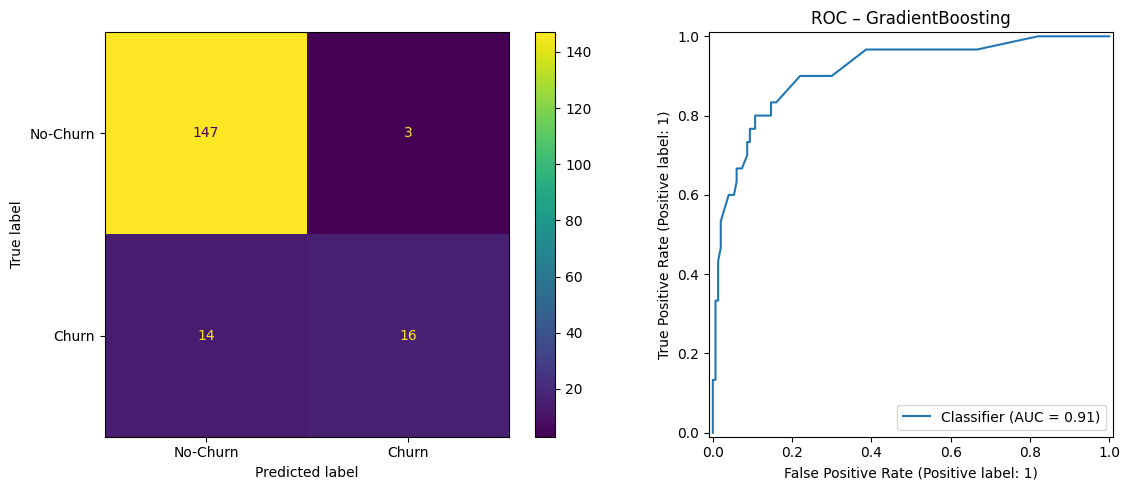

In [14]:
preds = best_pipe.predict(X_test)
proba = best_pipe.predict_proba(X_test)[:,1]

fig, ax = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay(confusion_matrix(y_test, preds),
                       display_labels=["No-Churn","Churn"]).plot(ax=ax[0])
RocCurveDisplay.from_predictions(y_test, proba, ax=ax[1])
plt.title(f"ROC – {best_name}")
plt.tight_layout()
plt.savefig("evaluation_plots.png", dpi=300)

Explainability – SHAP



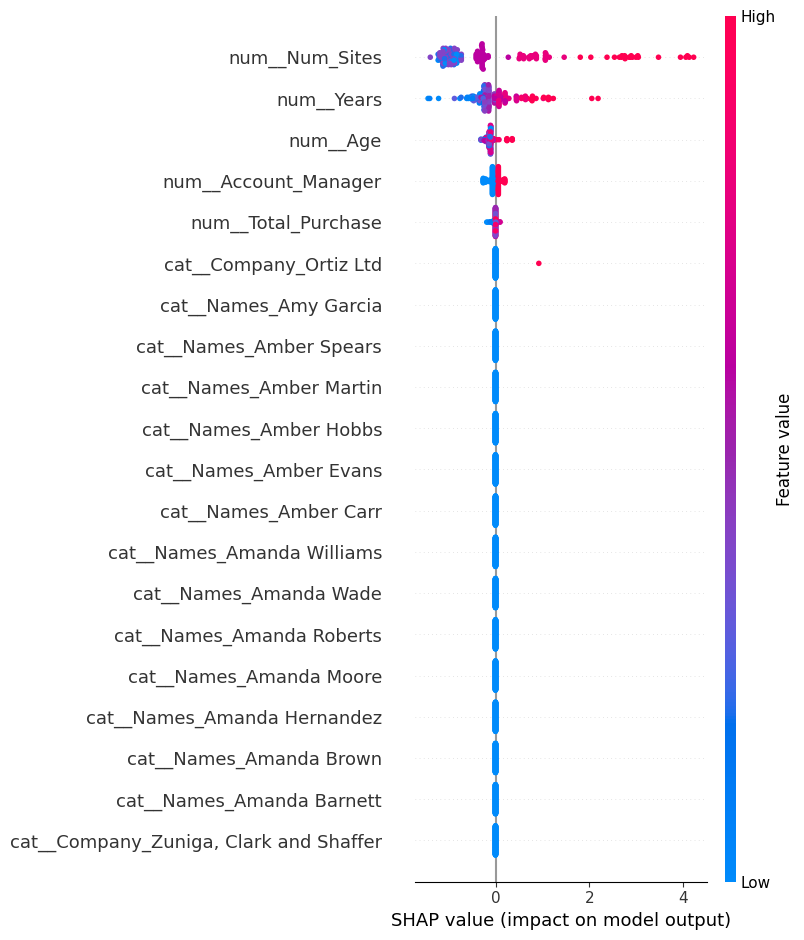

<Figure size 640x480 with 0 Axes>

In [ ]:

# Extract steps
best_model = best_pipe.named_steps["clf"]
prep = best_pipe.named_steps["prep"]

# Encode and ensure dense
X_test_enc = prep.transform(X_test)
X_test_enc_dense = X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc
feature_names = prep.get_feature_names_out()

# Fast explainers
if "xgb" in str(type(best_model)).lower() or "lgb" in str(type(best_model)).lower() \
   or "forest" in str(type(best_model)).lower():
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_enc_dense)
else:
    X_sample = shap.utils.sample(X_test_enc_dense, 200, random_state=0)
    explainer = shap.Explainer(best_model, X_sample)
    shap_values = explainer(X_test_enc_dense)

# Summary plot
shap.summary_plot(shap_values, X_test_enc_dense, feature_names=feature_names)
plt.savefig("shap_summary.png", bbox_inches="tight", dpi=300)

# Force plot for first customer
if isinstance(shap_values, list):  # multiclass tree output
    shap_vals_single = shap_values[1]  # select positive class
else:
    shap_vals_single = shap_values

# Avoid calling np.mean() on the Explanation object directly
# (np.mean would dispatch to Explanation.mean and pass dtype kwarg causing the TypeError).
# Instead compute base value and sample shap array explicitly.
base_val = float(np.mean(shap_vals_single.base_values))
sample_shap = shap_vals_single.values[0]

force = shap.force_plot(
    base_val, sample_shap, X_test_enc_dense[0, :],
    feature_names=feature_names
)
shap.save_html("shap_customer_0.html", force)


Cross-validated scores


In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = ["accuracy","precision","recall","f1","roc_auc"]

cv_results = cross_validate(best_pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
print("CV mean ROC-AUC:", cv_results["test_roc_auc"].mean())

CV mean ROC-AUC: 0.8875555555555555
